This notebook is used to show statistics about the sequences used in the training.

In [1]:
import os
import re
import yaml
import pickle

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
cd ../../src

/Users/cock/kDrive/PhD/Projects/Labs/beerslaw-lab/src


# Data

In [3]:
with open('../notebooks/debug_filter_data.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [4]:
len(data['sequences'])

254

In [5]:
training_ids = [data['sequences'][idx]['learner_id'] for idx in data['sequences']]

In [6]:
palette = ['#7400B8', '#6930C3', '#5E60CE', '#5390D9', '#4EA8DE', '#48BFE3', '#56CFE1', '#64DFDF', '#72EFDD', '#80FFDB']

# Average Lengths

In [7]:
def get_durations(sequencer_name:str, training_ids:list) -> list:
    sequenced_path = '../data/sequenced_simulations/' + sequencer_name + '/'
    files = os.listdir(sequenced_path)
    files = [f for f in files if 'sequenced.pkl' in f]

    # regex expression to retrieve id 
    id_regex = re.compile('lid([^_]+)_')
    perm_regex = re.compile('p_([^_]+)_')

    i = 0
    lengths = {}
    durations = {}
    years = {}
    permutations = {}
    while len(files) != 0:
        file = files[0]
        lid = id_regex.findall(file)[0]
        permutation = perm_regex.findall(file)[0]
        lengths_12 = 0
        durations_12 = 0
        
        file_path = 'p_' + str(permutation) + '_lid' + str(lid) + '_t2_sequenced.pkl'
        with open(sequenced_path + file_path, 'rb') as fp:
            sequence = pickle.load(fp)
            lengths_12 += len(sequence['sequence'])
            durations_12 += sequence['last_timestamp']
            if file_path in files:
                files.remove(file_path)

        file_path = 'p_' + str(permutation) + '_lid' + str(lid) + '_t3_sequenced.pkl'
        if file_path in files:
            files.remove(file_path)
        file_path = 'p_' + str(permutation) + '_lid' + str(lid) + '_t1_sequenced.pkl'
        if file_path in files:
            files.remove(file_path)
        if lid in training_ids:
            lengths[lid] = lengths_12
            durations[lid] = durations_12
            years[lid] = sequence['year']
            permutations[lid] = sequence['permutation']
    return lengths, durations, years, permutations

def plot_distribution_of_time(sequencer_name:str, training_ids:list):
    lengths, durations, years, permutations = get_durations(sequencer_name, training_ids)
    lengths = [lengths[x] for x in lengths]
    plt.figure(figsize=(12, 4))
    plt.hist(lengths, bins=list(range(0, 700, 25)), color=np.random.choice(palette))
    plt.ylim([0, 100])
    plt.xlim([0, 700])
    plt.xlabel('seconds')
    plt.xticks(list(range(0, 700, 100)))
    plt.title('Time Distribution')
    plt.show()
    
def plot_distribution_of_length(lengths, axis):
    lengths = [lengths[lid] for lid in lengths]
    axis.hist(lengths, bins=list(range(10, 1000, 50)), color=np.random.choice(palette))
    axis.set_ylim([0, 205])
    axis.set_title('length distribution')
    
def plot_lengths_vs_durations(lengths, durations, axis):
    durations = [durations[lid] for lid in lengths]
    lengths = [lengths[lid] for lid in lengths]
    
    axis.scatter(durations, lengths, color=np.random.choice(palette))
    axis.set_xlabel('duration (s)')
    axis.set_ylabel('lengths (#)')
    axis.set_xlim([0, 1500])
    axis.set_ylim([0, 1500])
    axis.set_title('lengths vs duration')
    
    
def plot(sequencer_name: str, sampling_rate:str, training_ids:list):
    fig, axis = plt.subplots(1, 2, figsize=(12, 4))
    
    lengths, durations, years, permutations = get_durations(sequencer_name, training_ids)
    plot_distribution_of_length(lengths, axis[0])
    plot_lengths_vs_durations(lengths, durations, axis[1])
    
    plt.suptitle('Sampling rate: {}'.format(sampling_rate))
    plt.show()



## state-action: seconds

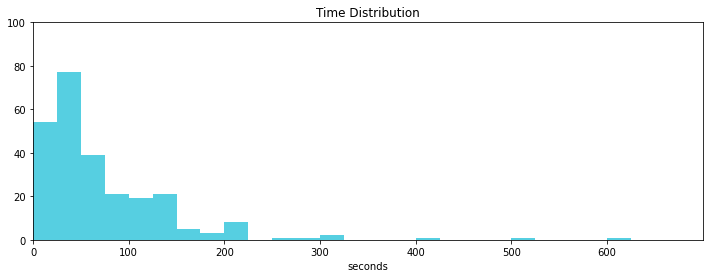

In [8]:
plot_distribution_of_time('stateaction_secondslstm', training_ids)

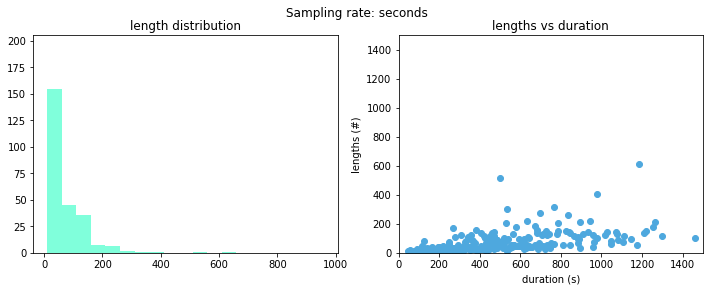

In [9]:
plot('stateaction_secondslstm', 'seconds', training_ids)

## state-action: encoded

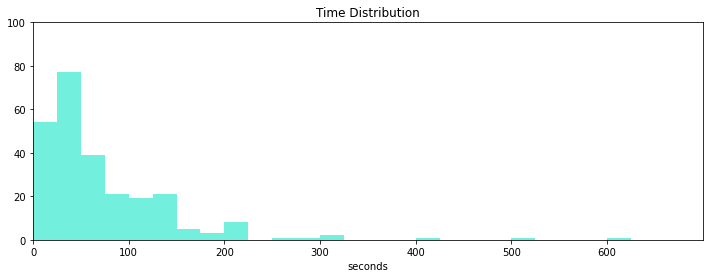

In [10]:
plot_distribution_of_time('stateaction_encodedlstm', training_ids)

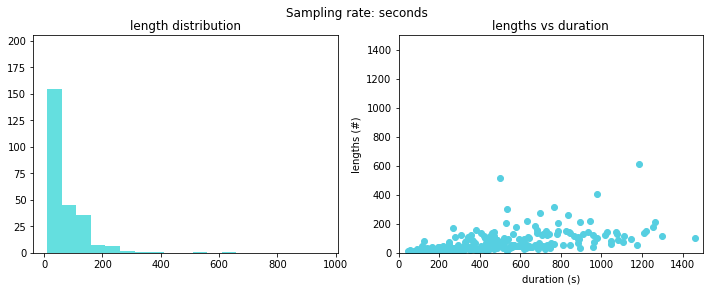

In [11]:
plot('stateaction_encodedlstm', 'seconds', training_ids)

## Adaptive 5 seconds

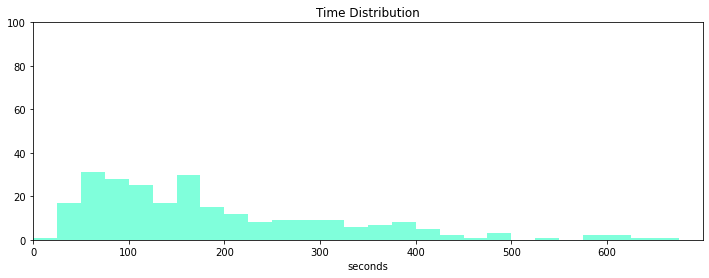

In [12]:
plot_distribution_of_time('stateaction_adaptivelstm_5_0-6_dac', training_ids)

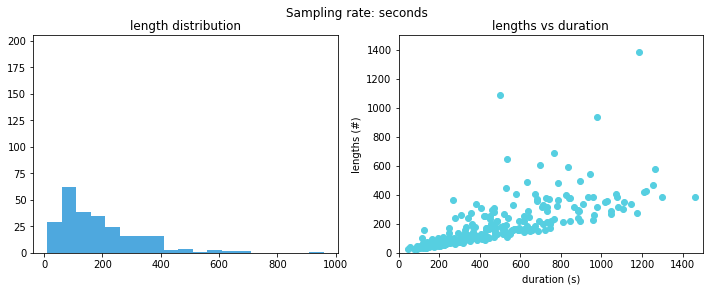

In [13]:
plot('stateaction_adaptivelstm_5_0-6_dac', 'seconds', training_ids)

## Adaptive 1 second

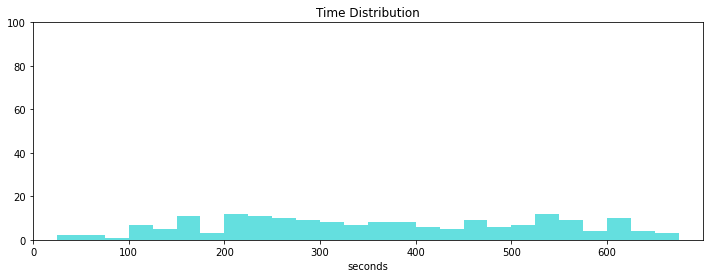

In [14]:
plot_distribution_of_time('stateaction_adaptivelstm_1_0-6_dac', training_ids)

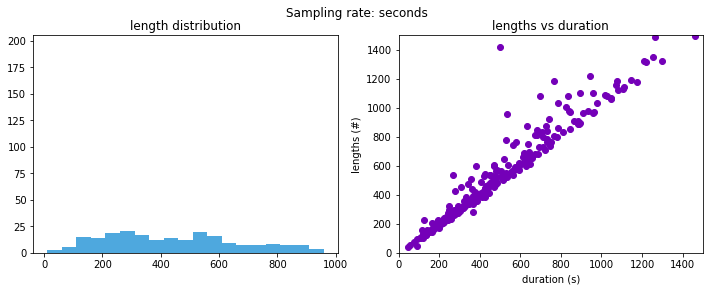

In [15]:
plot('stateaction_adaptivelstm_1_0-6_dac', 'seconds', training_ids)

## General statistics

In [16]:
lengths, durations, years, perms = get_durations('stateaction_secondslstm', training_ids)
with open('../data/experiment_keys/permutation_maps/vector_binary.yaml', 'r') as fp:
    permutation_map = yaml.load(fp, Loader=yaml.FullLoader)

There are 254 students with a ranking and more than 10 actions.
11 of them have an interaction shorter than 2 minutes.
11 of them have an interaction shorter than 2 minutes but more than 10 interactions.
0 of them have less than 10 interactions with the platform


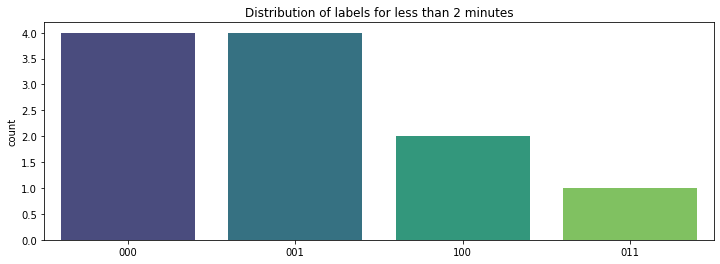

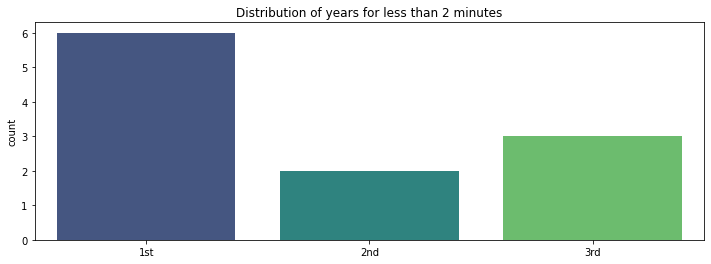

In [17]:
print('There are {} students with a ranking and more than 10 actions.'.format(len(lengths)))
less2minutes = [idx for idx in lengths if durations[idx] < 120]
print('{} of them have an interaction shorter than 2 minutes.'.format(len(less2minutes)))
less2minutesover10 = [idx for idx in lengths if durations[idx] < 120 and lengths[idx]>10]
print('{} of them have an interaction shorter than 2 minutes but more than 10 interactions.'.format(len(less2minutesover10)))
less10inte = [idx for idx in lengths if lengths[idx] < 10]
print('{} of them have less than 10 interactions with the platform'.format(len(less10inte)))

# Permutations for less than 2 minutes
permutations = [perms[idx] for idx in less2minutes]
permutations = [permutation_map['map'][perm] for perm in permutations]
sorting_index = [int(x[0]) + int(x[1]) + int(x[2]) for x in permutations]
sorting_index = np.argsort(sorting_index)
permutations = [permutations[i] for i in sorting_index]
plt.figure(figsize=(12, 4))
sns.countplot(x=permutations, palette='viridis')
plt.title('Distribution of labels for less than 2 minutes')
plt.show()

# Years
ys = [years[idx] for idx in less2minutes]
ys.sort()
plt.figure(figsize=(12, 4))
sns.countplot(x=ys, palette='viridis')
plt.title('Distribution of years for less than 2 minutes')
plt.show()

# Scores

In [21]:
with open('../data/post_test/rankings_scored.pkl', 'rb') as fp:
    rankings = pickle.load(fp)
    rankings = rankings[rankings['username'].isin(training_ids)]
    
with open('../data/experiment_keys/permutation_maps/vector_binary.yaml', 'r') as fp:
    permutation_map = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('./visualisers/maps/concat_labels.yaml', 'r') as fp:
    palette = yaml.load(fp, Loader=yaml.FullLoader)
    palette = palette['vector_labels']
    palette['q1'] = '#071013'
    palette['q2'] = '#23B5D3'
    palette['q3'] = '#75ABBC'
    palette['q4'] = '#A2AEBB'
    palette['q5'] = '#DFE0E2'
    palette['q6'] = '#6E633D'
colour_palette = ['#7400B8', '#6930C3', '#5E60CE', '#5390D9', '#4EA8DE', '#48BFE3', '#56CFE1', '#64DFDF', '#72EFDD', '#80FFDB']

In [22]:
rankings_columns = [
    'username', 'field', 'level', 'year', 'consent', 'gender',
    'ranking', 'q1_conf', 'q2_conf', 'q3_conf', 'q4_conf', 
    'notes_text', 'notes_math', 'notes_table', 'notes_diag', 'notes_time', 
    'beerslaw', 'beerslaw_conf', 
    'feedback_entertain', 'feedback_difficult', 'feedback_good', 'feedback_bad', 'feedback',
    'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'q6_score', 'q5_colour1', 'q6_colour1'
]
ranks = rankings[rankings_columns]
ranks['vector_label'] = ranks['ranking'].apply(lambda x: permutation_map['map'][x])

/var/folders/jy/0pp1md9x1358dt8g8k69srhr0000gp/T/ipykernel_51940/2886883294.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranks['vector_label'] = ranks['ranking'].apply(lambda x: permutation_map['map'][x])


## Scores
### Score Labels

In [23]:
def get_n_people(df, question:str, score:int) -> int:
    """
    This function returns the amount of people who got score *score* for question *question*
    """
    return len(df[df[question] == score])

def get_percent_people(df, question, score:int) -> float:
    return len(df[df[question] == score]) / len(df)

def plot_axis(axis, df, name):
    x = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16]
    x_ticks = ['wrong', 'correct', 'wrong', 'correct', 'wrong', 'correct', 'wrong', 'correct', 'wrong','correct', 'wrong', 'correct']
    y = [
        get_percent_people(df, 'q1_score', 0),
        get_percent_people(df, 'q1_score', 1),
        get_percent_people(df, 'q2_score', 0),
        get_percent_people(df, 'q2_score', 1),
        get_percent_people(df, 'q3_score', 0),
        get_percent_people(df, 'q3_score', 1),
        get_percent_people(df, 'q4_score', 0),
        get_percent_people(df, 'q4_score', 1),
        get_percent_people(df, 'q5_score', 0),
        get_percent_people(df, 'q5_score', 1),
        get_percent_people(df, 'q6_score', 0),
        get_percent_people(df, 'q6_score', 1),
    ]

    axis.bar(x[0:2], y[0:2], label='width', color=palette['q1'])
    axis.bar(x[2:4], y[2:4], label='conc', color=palette['q2'])
    axis.bar(x[4:6], y[4:6], label='w&c', color=palette['q3'])
    axis.bar(x[6:8], y[6:8], label='w&c', color=palette['q4'])
    axis.bar(x[8:10], y[8:10], label='colour', color=palette['q5'])
    axis.bar(x[10:], y[10:], label='colour', color=palette['q6'])
    
    axis.set_xticks(x)
    axis.set_xticklabels(x_ticks)
    
    axis.set_xlabel(name)
    axis.set_ylim([0, 1])
    axis.set_ylabel('#apprentices')
    axis.legend()
    
def plot_question_labels():
    fig, axis = plt.subplots(4, 2, figsize=(24, 15))

    v000 = ranks[ranks['vector_label'] == '000']
    v100 = ranks[ranks['vector_label'] == '100']
    v010 = ranks[ranks['vector_label'] == '010']
    v001 = ranks[ranks['vector_label'] == '001']
    v110 = ranks[ranks['vector_label'] == '110']
    v101 = ranks[ranks['vector_label'] == '101']
    v011 = ranks[ranks['vector_label'] == '011']
    v111 = ranks[ranks['vector_label'] == '111']

    plot_axis(axis[0, 0], v000, '000')
    plot_axis(axis[0, 1], v100, '100')
    plot_axis(axis[1, 0], v010, '010')
    plot_axis(axis[1, 1], v001, '001')
    plot_axis(axis[2, 0], v110, '110')
    plot_axis(axis[2, 1], v101, '101')
    plot_axis(axis[3, 0], v011, '011')
    plot_axis(axis[3, 1], v111, '111')
    
    plt.suptitle('Score distribution for colour - concentration - width')
    plt.show()




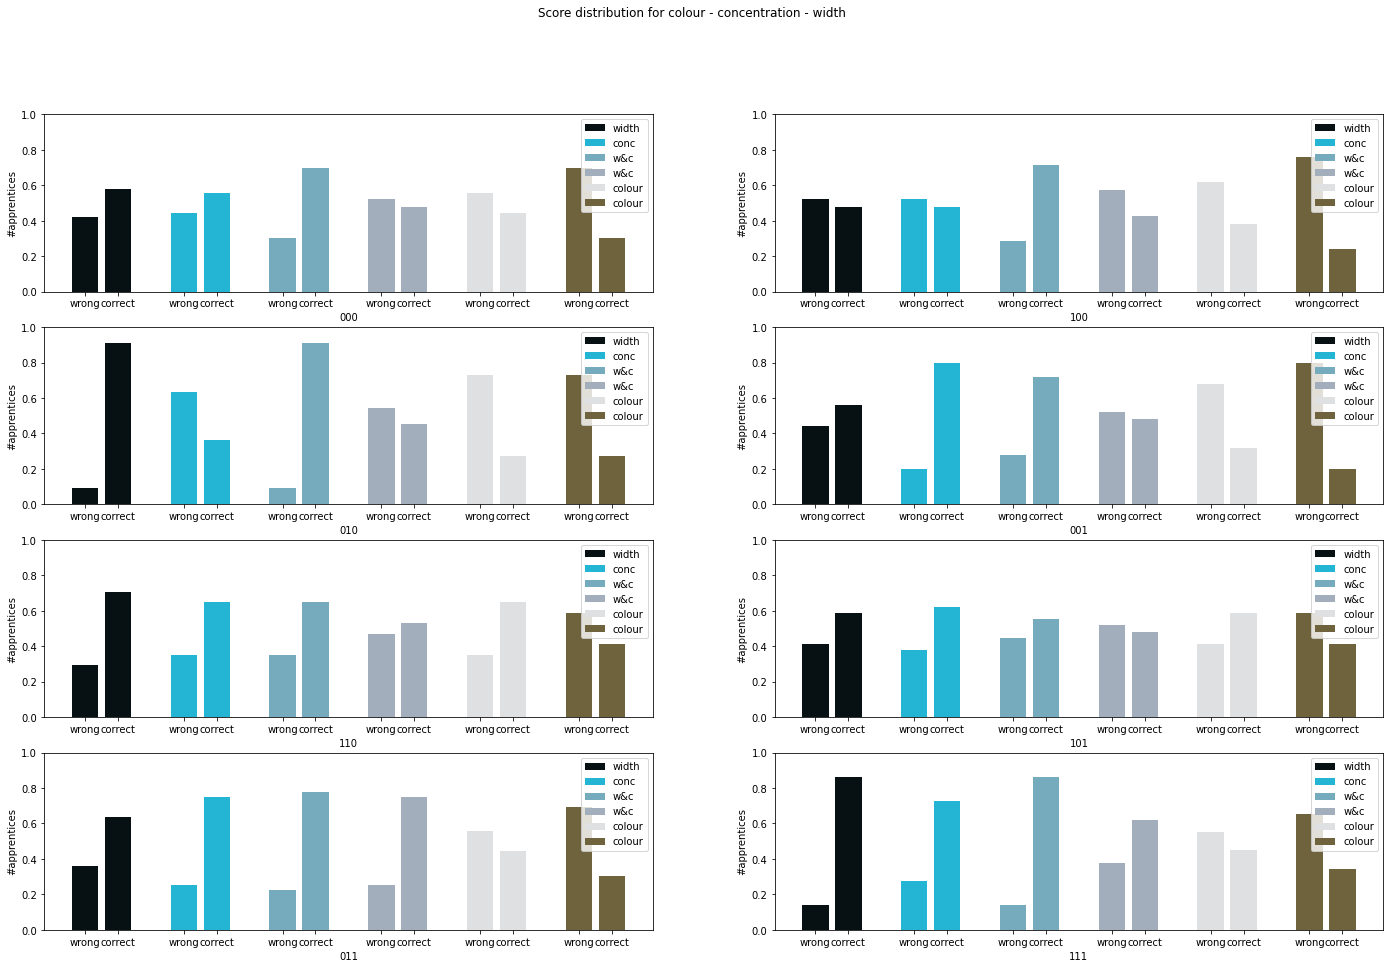

In [24]:
plot_question_labels()

In [25]:
def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_distribution(df, question:str, attribute:str, axis):
    """
    Make distribution of score + confidence boxplot for each score for question *question*, for group
    with attribute *attribute*
    """
    score_column = question + '_score'
    conf_column = question + '_conf'
    
    # correct vs wrong answers
    wrong = df[(df[score_column] == 0) & (df[conf_column] != 'missing')]
    correct = df[(df[score_column] == 1) & (df[conf_column] != 'missing')]
    
    # score distribution
    axis.bar([1, 2], [len(wrong)*100/len(df), len(correct)*100/len(df)], alpha=0.3, color=palette[question])
    # confidence boxplot
    axis.boxplot([wrong[conf_column].astype(int), correct[conf_column].astype(int)])
    
    #aesthetic
    axis.set_xticklabels(['wrong', 'correct'])
    axis.set_title(question + ' - ' + attribute)
    

def get_average_confidence(row):
    conf = 0
    nr = 0
    if row['q1_conf'] != 'missing':
        conf += int(row['q1_conf'])
        nr += 1
    if row['q2_conf'] != 'missing':
        conf += int(row['q2_conf'])
        nr += 1
    if row['q3_conf'] != 'missing': 
        conf += int(row['q3_conf'])
        nr += 1
    if row['q4_conf'] != 'missing':
        conf += int(row['q4_conf'])
        nr += 1
    if row['q5_colour1'] != 'missing':
        conf += int(row['q5_colour1'])
        nr += 1
    if row['q6_colour1'] != 'missing':
        conf += int(row['q6_colour1'])
        nr += 1
        
    return conf / nr
    
def confidence_plot_scores(df, axis, title_addendum):
    """
    takes df, and creates the average confidence plot for each post test scores
    """
    df['overall_score'] = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score'] + df['q5_score'] + df['q6_score']
    print(df.columns)
    df['average_confidence'] = df.apply(get_average_confidence, axis=1)

    zero = df[(df['overall_score'] == 0)]
    one = df[(df['overall_score'] == 1)]
    two = df[(df['overall_score'] == 2)]
    third = df[(df['overall_score'] == 3)]
    fourth = df[(df['overall_score'] == 4)]
    fifth = df[(df['overall_score'] == 5)]
    sixth = df[(df['overall_score'] == 6)]

    # score distribution
    axis.bar(
        [1, 2, 3, 4, 5, 6, 7],
        [len(zero)*100/len(df), len(one)*100/len(df), len(two)*100/len(df), 
         len(third)*100/len(df), len(fourth)*100/len(df), len(fifth)*100/len(df), len(sixth)*100/len(df)], 
        alpha=0.3, color=[palette['q1'], palette['q2'], palette['q3'], palette['q4'], palette['000'], 'yellowgreen', 'greenyellow']
    )
    # confidence boxplot
    axis.boxplot([
        zero['average_confidence'].astype(int), one['average_confidence'].astype(int),
        two['average_confidence'].astype(int), third['average_confidence'].astype(int),
        fourth['average_confidence'].astype(int), fifth['average_confidence'].astype(int),
        sixth['average_confidence'].astype(int)
    ])

    #aesthetic
    axis.set_xticklabels([0, 1, 2, 3, 4, 5, 6])
    axis.set_xlabel('scores')
    axis.set_ylabel('%confidence')
    axis.set_title('Confidence levels per scores' + title_addendum)



/var/folders/jy/0pp1md9x1358dt8g8k69srhr0000gp/T/ipykernel_51940/631889256.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overall_score'] = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score'] + df['q5_score'] + df['q6_score']
/var/folders/jy/0pp1md9x1358dt8g8k69srhr0000gp/T/ipykernel_51940/631889256.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['average_confidence'] = df.apply(get_average_confidence, axis=1)
/var/folders/jy/0pp1md9x1358dt8g8k69srhr0000gp/T/ipykernel_51940/6

Index(['username', 'field', 'level', 'year', 'consent', 'gender', 'ranking',
       'q1_conf', 'q2_conf', 'q3_conf', 'q4_conf', 'notes_text', 'notes_math',
       'notes_table', 'notes_diag', 'notes_time', 'beerslaw', 'beerslaw_conf',
       'feedback_entertain', 'feedback_difficult', 'feedback_good',
       'feedback_bad', 'feedback', 'q1_score', 'q2_score', 'q3_score',
       'q4_score', 'q5_score', 'q6_score', 'q5_colour1', 'q6_colour1',
       'vector_label', 'overall_score'],
      dtype='object')
Index(['username', 'field', 'level', 'year', 'consent', 'gender', 'ranking',
       'q1_conf', 'q2_conf', 'q3_conf', 'q4_conf', 'notes_text', 'notes_math',
       'notes_table', 'notes_diag', 'notes_time', 'beerslaw', 'beerslaw_conf',
       'feedback_entertain', 'feedback_difficult', 'feedback_good',
       'feedback_bad', 'feedback', 'q1_score', 'q2_score', 'q3_score',
       'q4_score', 'q5_score', 'q6_score', 'q5_colour1', 'q6_colour1',
       'vector_label', 'overall_score'],
      

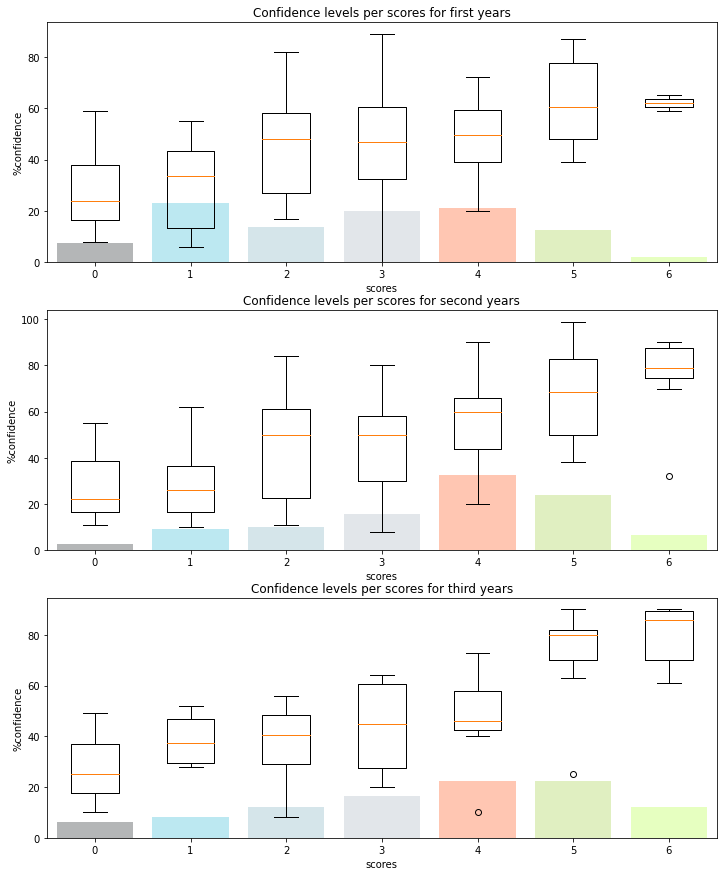

In [26]:
fig, axis = plt.subplots(3, 1, figsize=(12, 15))

year1 = get_sub_df(ranks, 'year', '1st')
confidence_plot_scores(year1, axis[0], ' for first years')

year2 = get_sub_df(ranks, 'year', '2nd')
confidence_plot_scores(year2, axis[1], ' for second years')

year3 = get_sub_df(ranks, 'year', '3rd')
confidence_plot_scores(year3, axis[2], ' for third years')

plt.show()

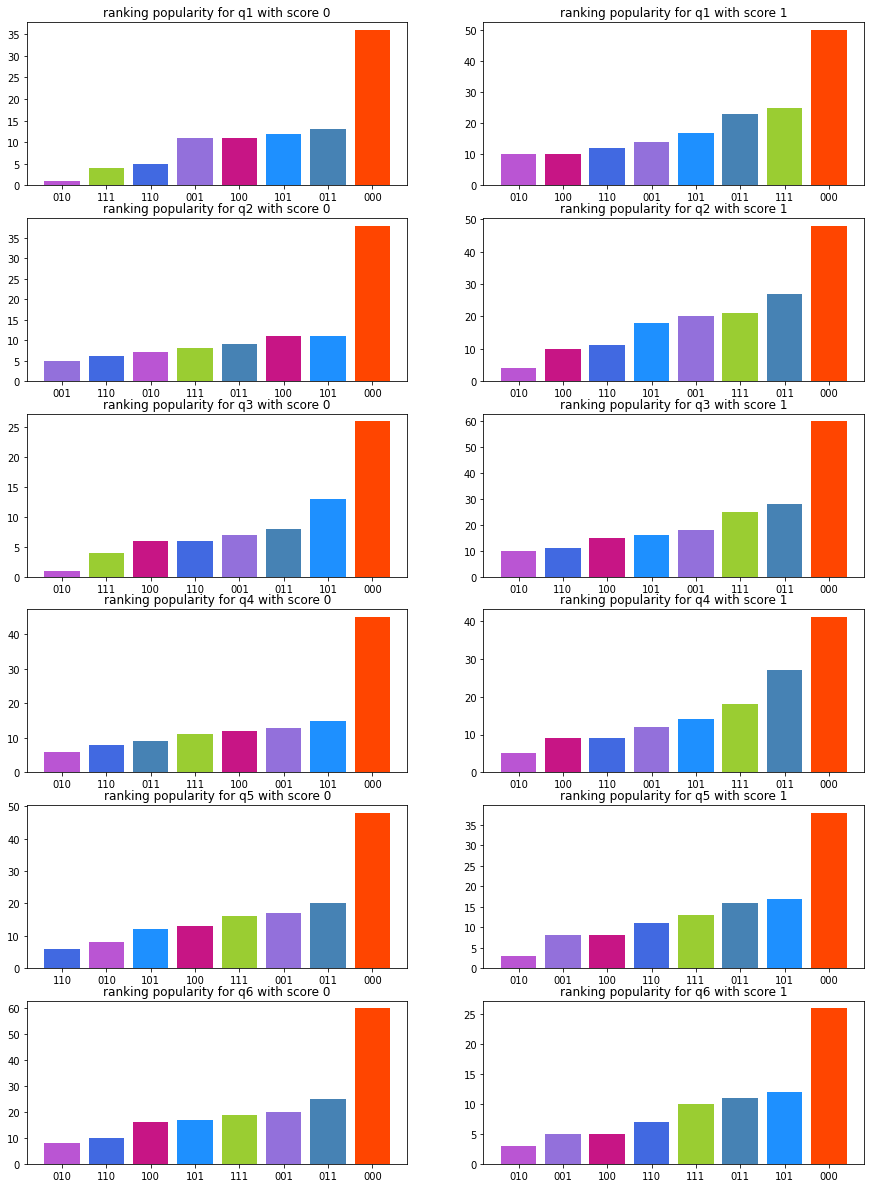

In [26]:
def subplot_ranking_question(df, question:str, correct:int, axis):
    '''
    plots the distribution of people in each ranking for a particular 'question' with a particular 'correct' score
    '''
    q = get_sub_df(df, question + '_score', correct)
    q = q.groupby('vector_label').nunique()['username'].reset_index().sort_values('username')
    axis.bar(range(len(q)), q['username'], color=[palette[c] for c in q['vector_label']])
    axis.set_xticks(range(len(q)))
    axis.set_xticklabels(q['vector_label'])
    axis.set_title('ranking popularity for ' + question + ' with score ' + str(correct))

fig, axis = plt.subplots(6, 2, figsize=(15, 21))
subplot_ranking_question(ranks, 'q1', 0, axis[0, 0])
subplot_ranking_question(ranks, 'q1', 1, axis[0, 1])

subplot_ranking_question(ranks, 'q2', 0, axis[1, 0])
subplot_ranking_question(ranks, 'q2', 1, axis[1, 1])

subplot_ranking_question(ranks, 'q3', 0, axis[2, 0])
subplot_ranking_question(ranks, 'q3', 1, axis[2, 1])

subplot_ranking_question(ranks, 'q4', 0, axis[3, 0])
subplot_ranking_question(ranks, 'q4', 1, axis[3, 1])

subplot_ranking_question(ranks, 'q5', 0, axis[4, 0])
subplot_ranking_question(ranks, 'q5', 1, axis[4, 1])

subplot_ranking_question(ranks, 'q6', 0, axis[5, 0])
subplot_ranking_question(ranks, 'q6', 1, axis[5, 1])



# Overall statistics

In [44]:
rankings = rankings[rankings['username'].isin(training_ids)]

In [45]:
len(training_ids)

254

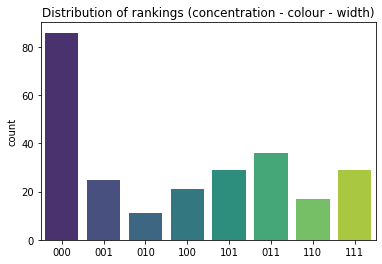

In [61]:
rs = rankings['ranking']
rs = [permutation_map['map'][r] if r in permutation_map['map'] else 0 for r in rs]
rs_idx = [int(r[0]) + int(r[1]) + int(r[2]) for r in rs]
idx = np.argsort(rs_idx)
rs = [rs[i] for i in idx]
sns.countplot(x=rs, palette='viridis')
plt.title('Distribution of rankings (concentration - colour - width)')
plt.show()

In [ ]:
rs = rankings['ranking']
rs = [permutation_map['map'][r] if r in permutation_map['map'] else 0 for r in rs]
rs_idx = [int(r[0]) + int(r[1]) + int(r[2]) for r in rs]
idx = np.argsort(rs_idx)
rs = [rs[i] for i in idx]
sns.countplot(x=rs, palette='viridis')
plt.title('Distribution of rankings (concentration - colour - width)')
plt.show()

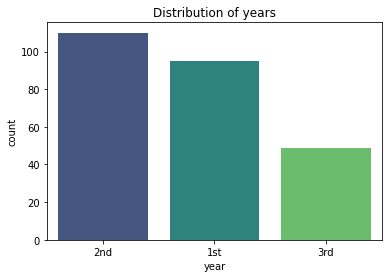

In [49]:
sns.countplot(x=rankings['year'], palette='viridis')
plt.title('Distribution of years')
plt.show()

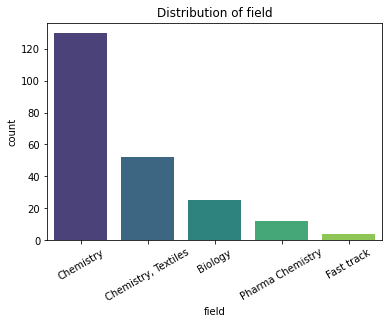

In [55]:
sns.countplot(x=rankings['field'], palette='viridis')
plt.title('Distribution of field')
plt.xticks(rotation=30)
plt.show()

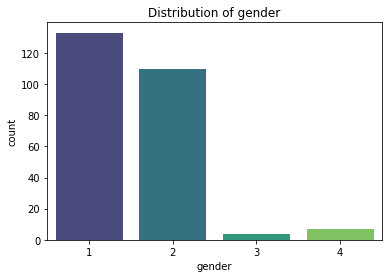

In [56]:
sns.countplot(x=rankings['gender'], palette='viridis')
plt.title('Distribution of gender')
plt.show()

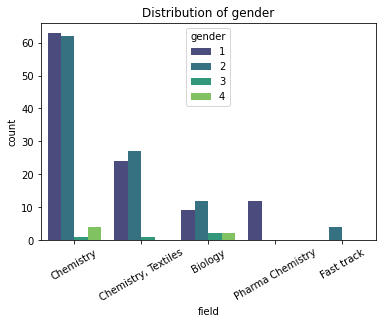

In [60]:
sns.countplot(x='field', hue='gender', data=rankings, palette='viridis')
plt.title('Distribution of gender')
plt.xticks(rotation=30)
plt.show()

## Per Question

In [50]:
rankings['label_vector'] = rankings['ranking'].apply(lambda x: permutation_map['map'][x])
rankings['label_binary'] = rankings['label_vector'].apply(lambda x: int(int(x[0]) + int(x[1]) + int(x[2]) >= 2))

In [90]:
def subplot_distributionlabel_question(df, question_score_column, axis):
    scores = df[question_score_column].unique()
    scores.sort()
    
    i = 0
    xs = []
    xticks = []
    heights = []
    colours = []
    labels = []
    for score in scores:
        score_df = df[df[question_score_column] == score]
        
        # label = 0
        height_0 = len(score_df[score_df['label_binary'] == 0]) / len(score_df)
        height_1 = len(score_df[score_df['label_binary'] == 1]) / len(score_df)
        
        xs = xs + [i, i+1]
        xticks = xticks + [i, i+0.5, i+1]
        labels = labels + ['< 2', 'score='+str(score), '>= 2']
        heights = heights + [height_0, height_1]
        colours = colours + ['#0496ff', '#ffbc42']
        
        i += 3
        
        
    axis.bar(xs, heights, color=colours)
    axis.set_xticks(xticks)
    axis.set_xticklabels(labels)
    axis.set_title('scores for question ' + question_score_column[0:2])


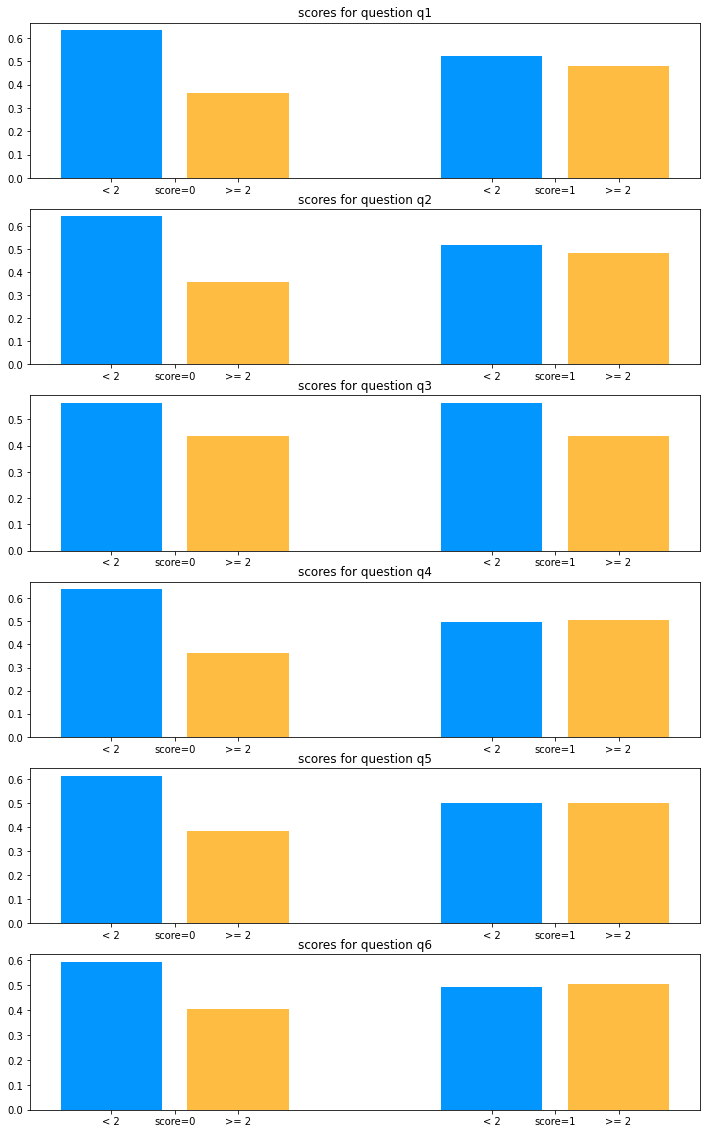

In [91]:
fig, axis = plt.subplots(6, 1, figsize=(12, 20))
subplot_distributionlabel_question(rankings, 'q1_score', axis[0])
subplot_distributionlabel_question(rankings, 'q2_score', axis[1])
subplot_distributionlabel_question(rankings, 'q3_score', axis[2])
subplot_distributionlabel_question(rankings, 'q4_score', axis[3])
subplot_distributionlabel_question(rankings, 'q5_score', axis[4])
subplot_distributionlabel_question(rankings, 'q6_score', axis[5])